In [ ]:
# Ввод необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import enum 
import scipy.optimize as optimize
import datetime
import statsmodels.api as sm
import pandas as pd
import time
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Вводим мнимую единицу i
np.set_printoptions(precision = 5)
i   = np.complex(0.0,1.0)

# Вводим класс отражающий тип опциона

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Функция вычисления стоимости опциона 
def CallPutOptionPriceCOSMthd(par, CP, S0, r, tau, K, N, L):
    # par  - параметры модели
    # CP   - тип опциона
    # S0   - начальная цена базового актива
    # r    - процентная ставка (постоянная)
    # tau  - время до экспирации
    # K    - лист страйков
    # N    - число элементов в разложении
    # L    - определяет величину отсечения пространства (L=8 или L=10)
    # меняем размер K - теперь K вектор
    if K is not np.array:
        K = np.array(K).reshape([len(K), 1])
    
    i = np.complex(0.0, 1.0) 
    x0 = np.log(S0 / K)   
    
    # усечённое пространство
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Суммирование по k = 0 до k = N-1
    k = np.linspace(0, N-1, N).reshape([N, 1])  
    u = k * np.pi / (b - a);  

    # определяем коэффициенты и характеристическую функцию
    cf = ChFBSModel(r,tau, par)
    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0] 
    # суммируем полученные коэффициенты   
    val = np.exp(-r * tau) * K * np.real(mat.dot(temp))     
    return val


In [ ]:
# вычисление коэффициентов для соответствующего типа опционов
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k   

In [ ]:
# вспомогательная функция для вычисления коэффициентов в сумме
def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

In [ ]:
# формула Блэка - Шоулса для стоимости опциона

def BS_Call_Option_Price(CP, S_0, K, sigma, tau, r):
    
    K = np.array(K).reshape([len(K),1])
    sigma = np.array(sigma).reshape([len(sigma),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value


In [ ]:
# вычисление подразумеваемой волатильности по цене опциона, страйку, времени до экспирации
# в качестве метода поиска корня используется метод Ньютона Рафсона
def ImpliedVolatility(CP,marketPrice,K,T,S_0,r):
    func = lambda sigma: np.power(BS_Call_Option_Price(CP,S_0,K,sigma,T,r) - marketPrice,1.0)
    impliedVol = optimize.newton(func, 0.7, tol=1e-5)
    return impliedVol


In [ ]:
# вычисление характеристической функции в модели Блэка-Шоулса
def ChFBSModel(r,tau,par):

    sigma = par[0]
    

    i = np.complex(0.0,1.0)  

    cf = lambda u: np.exp((r-(sigma ** 2) / 2) * i * u * tau - (sigma ** 2 ) * (u**2) * tau / 2)
    return cf 

In [ ]:
# генератор путей методом Эйлера с поглощением в 0 вариации в одномерной модели Хестона
def GeneratePathsBSEuler(NoOfPaths, NoOfSteps, T, r, S_0, sigma):  
    # параметры (1=kappa, 2=gamma, 3=vbar, 4=v0, 5=rho)  
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    
   
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    X[:,0]=np.log(S_0)
    time = np.zeros([1, NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):

        # убеждаемся, что элементы выборки из нормального распределения со средним 0 и дисперсией 1

        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
            
        
        
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
     
        X[:,i+1] = X[:,i] + (r - 0.5*sigma)*dt + sigma*(W[:,i+1]-W[:,i])
        
        time[0][i+1] = time[0][i] +dt
        
    # Compute exponent

    S = np.exp(X)
    paths = {"time":time,"S":S}
    return paths

In [ ]:
# моделирование двухмерной коррелированной модели Блэка-Шоулса на основе моделирования методом Эйлера
# возвращает 2 путя, и время
def BS2path(par1, par2, NoOfSteps, T, mu, S_01, S_02, rho12):
  # параметры (1=kappa, 2=gamma, 3=vbar, 4=v0, 5=rho)
  # мгновенная кореляция между активами
  Z1 = np.random.normal(0.0,1.0,[1, NoOfSteps])
  Z2 = np.random.normal(0.0,1.0,[1, NoOfSteps])
  
  W1 = np.zeros([1, NoOfSteps + 1])
  W2 = np.zeros([1, NoOfSteps + 1])
  
  X1 = np.zeros([1, NoOfSteps + 1])
  X2 = np.zeros([1, NoOfSteps + 1])
  
  X1[:,0] = np.log(S_01)
  X2[:,0] = np.log(S_02)
  time = np.zeros([1, NoOfSteps+1])    
  dt = T / float(NoOfSteps)
  for i in range(0,NoOfSteps):
       
        Z2[:,i] = rho12 * Z1[:,i] + np.sqrt(1.0-rho12**2) * Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
          
        X1[:,i+1] = X1[:,i] + (mu[0] - 0.5 * par1 * par1) * dt + par1 * (W1[:,i+1]-W1[:,i])
        X2[:,i+1] = X2[:,i] + (mu[1] - 0.5 * par2 * par2) * dt +par2 * (W2[:,i+1]-W2[:,i])
        
        time[0][i+1] = time[0][i] + dt
  return np.exp(X1), np.exp(X2), time    

In [ ]:
# функция для подсчёта выборочной корреляции между двумя приращениями логарифмических цен двух путей
def EmpCorr(path1, path2):
  return np.corrcoef([np.log(path1[j + 1]/path1[j]) for j in range(len(path1) - 1)], [np.log(path2[j + 1]/path2[j]) for j in range(len(path2) - 1)])[0][1]


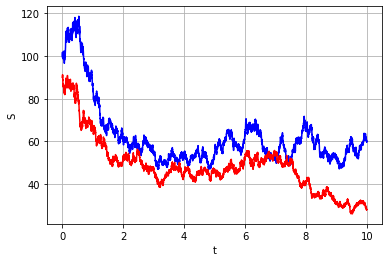

In [ ]:
NoOfSteps = 10000
# параметры (1=kappa, 2=gamma, 3=vbar, 4=v0, 5=rho)
par1 = [0.2]
par2 = [0.2]
T = 10
r = 0.06
S_01 = 100
S_02 = 90
rho12 = 0

a = BS2path(par1, par2, NoOfSteps, T, r, S_01, S_02, rho12)


plt.figure(1)
plt.plot(a[2][0], a[0][0],'b')
plt.plot(a[2][0], a[1][0],'r')
plt.xlabel("t")
plt.ylabel("S")
plt.grid()   



In [ ]:
# функция для подсчёта ожидаемой выборочной корреляции
def E_rho_emp(N, par1, par2, NoOfSteps, T, mu, S_01, S_02, rho12):
  s = 0
  for i in range(N):
    a = BS2path(par1, par2, NoOfSteps, T, mu, S_01, S_02, rho12)
    s += EmpCorr(a[0][0], a[1][0])
  return s / N

In [ ]:
#K = [1, 5, 10, 20, 50]
K = 10
NoOfSteps = [100, 200]
rho12 = -0.1
for i in NoOfSteps:
  print(E_rho_emp(i, par1, par2, i, T, r, S_01, S_02, rho12))

NameError: ignored

In [ ]:
# калибровка(на основе метода бисекций) для вычисления мгновенной корреляции между двумя активами при данной исторической корреляции и откалиброванными параметрами модели
def Bis_opt(N, par1, par2, NoOfSteps, T, mu, S_01, S_02, rho_emp, eps):
    # N - количество слагаемых для вычисления матожидания
    # par1, par2 - откалиброванные параметры модели для 1 и 2 актива соответственно
    # NoOfSteps - количество шагов в моделировании путей
    # S_01, S_02 - начальные цены активов
    # rho_emp - историческая корреляция
    # eps - допустимая погрешность
    rho_l = -1
    rho_u = 1
    E_l = E_rho_emp(N, par1, par2, NoOfSteps, T, mu, S_01, S_02, rho_l) - rho_emp
    rho_emp_new = 0.5 * (rho_l + rho_u)
    E_delta = E_rho_emp(N, par1, par2, NoOfSteps, T, mu, S_01, S_02, rho_emp_new) - rho_emp
    if (rho_emp > 0.99 and rho_emp <= 1) or (rho_emp < -0.99 and rho_emp >= -1.0):
      eps = 1e-2
    
    while abs(E_delta) > eps:
      if E_l * E_delta < 0:
        rho_u = rho_emp_new
        rho_emp_new = 0.5 * (rho_l + rho_u)
        E_delta = E_rho_emp(N, par1, par2, NoOfSteps, T, mu, S_01, S_02, rho_emp_new) - rho_emp
        
      else:
        rho_l = rho_emp_new
        E_l = E_delta
        rho_emp_new = 0.5 * (rho_l + rho_u)
        E_delta = E_rho_emp(N, par1, par2, NoOfSteps, T, mu, S_01, S_02, rho_emp_new) - rho_emp
        
    return rho_emp_new


In [ ]:
eps = 1e-3
rho_emp = [i/10 for i in range(-9, 11)]

print(rho_emp)
NoOfSteps = 200
K = 20
# параметры (1=kappa, 2=gamma, 3=vbar, 4=v0, 5=rho)
par1 = [1, 0.05, 0.3, 0.2, -0.7]
par2 = [0.5, 0.025, 0.2, 0.25, -0.5]
for i in rho_emp:
  print('{}: '.format(i), Bis_opt(K, par1, par2, NoOfSteps, T, r, S_01, S_02, i, eps))

[-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
-0.9:  -0.901123046875
-0.8:  -0.8054666817188263
-0.7:  -0.7060778141021729
-0.6:  -0.5927734375
-0.5:  -0.5
-0.4:  -0.39876556396484375
-0.3:  -0.31298923539232604
-0.2:  -0.19954385451273993
-0.1:  -0.109619140625
0.0:  0.000765971839427948
0.1:  0.09991299007441512
0.2:  0.2187519082799625
0.3:  0.29815463235149764
0.4:  0.3826904296875
0.5:  0.4997419281830844
0.6:  0.6015625
0.7:  0.69805908203125
0.8:  0.804931640625
0.9:  0.9042978286743164
1.0:  0.9921875


In [ ]:
#Проверка, что все элементы вектора положительные. Нужно для проверки положительной определённости матрицы. 
def check_pos_def(vec):
  for i in vec:
    if i <= 0:
      return False
  return True

In [ ]:
# нахождение индекса элемента массива, у которого округлённое значение совпадает с elem 
def findind(arr, elem, par = 4):
  for i, j in enumerate(arr):
    if round(j, par) == elem:
      return i
  return False 

In [ ]:
# разложение Холецкого, предполагается, что на вход подаётся положительно определенная симметричная матрица. После выполнения процедуры регуляризации 
#в python всё равно может оказаться, что под корнем будет очень маленькое отрицательное значение, тогда оно заменяется на очень маленькое положительное значение
def chol(M):
  L = np.zeros([len(M[0]), len(M[0])])
  for j in range(len(M[0])):
    for i in range(j, len(M[0])):
      if i == 0 and j == 0:
        L[i, j] = np.sqrt(M[i, j])
      if i == j and i != 0 and j != 0:
        if M[i, j] - np.sum(np.array([L[i, k] ** 2 for k in range(j)])) <= 0:
          L[i, j] = 10e-5
        else:
          L[i, j] = np.sqrt(M[i, j] - np.sum(np.array([L[i, k] ** 2 for k in range(j)])))
      else:
        L[i, j] = (M[i, j] - np.sum(np.array([L[j, k] * L[i, k ] for k in range(j)])))/L[j, j]
  return L

In [ ]:
# Процедура регуляризации
def Janckel_reg(M):
  w, v = np.linalg.eig(M)
  
  if check_pos_def(w) == True:
    return chol(M)
  else:
    Lambda = np.zeros([len(w), len(w)])
    sp = np.zeros([len(w)])
    for i in range(len(w)):
      if w[i] >= 0:
        Lambda[i][i] = w[i]
        sp[i] = w[i] 
    T = np.zeros([len(w), len(w)])
    for i in range(len(w)):
      T[i][i] = 1/(np.power(v[i], 2).dot(sp))
    
    B = np.dot(np.dot(np.sqrt(T), v), np.sqrt(Lambda))
    Cnew = np.dot(B, np.transpose(B))
    w, v = np.linalg.eig(Cnew)
    for i in range(len(Cnew)):
        Cnew[i, i] = 1
    return chol(Cnew)

In [ ]:
# генерация многомерного пути динамики акций в модели Блэка-Шоулза.
def multi_asset_path(par_model, corr_matrix, parS0, T, r, NoOfSteps):
    # на вход:
    # par_model - лист параметров моделей, в случае модели Блэка-Шоулза одномерный
    # Матрица посчитанных мгновенных корреляций между броуновскими движениями активов
    # parS0 - одномерный лист начальных стоимостей акций
    # T - время экспирации
    # r - процентная ставка
    # NoOfSteps - количество шагов
   
    X = np.zeros([len(parS0),  NoOfSteps+1]) 
    # проводим регуляризацию, если  матрица неположительно определена, на выходе разложение Холецкого 
    L = Janckel_reg(corr_matrix)
    sigma = np.zeros([1, len(parS0)])
    Z = np.random.normal(0.0,1.0,[len(parS0), NoOfSteps])
    W = np.zeros([len(parS0), NoOfSteps + 1])
    for i in range(len(parS0)):
      X[i, 0] = np.log(parS0[i])
      sigma[0, i] = par_model[i]
    #print(sigma)
    #print(sigma * sigma)
    time = np.zeros([NoOfSteps+1])
    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        time[i+1] = time[i] + dt
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        X[:, i+1] = X[:, i] + (r  - sigma * sigma/2) * dt +sigma * np.dot(L, (W[:,i+1]-W[:,i])).reshape([1, len(parS0)])[0]
        
    return np.exp(X), time

[1.] [[1.]]


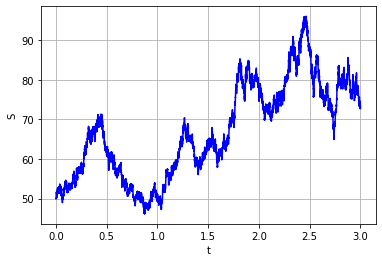

In [ ]:
par_model = [0.3]
par_S_0 = [50]
rho_emp_matr = np.array([[1.]])
T = 3
r = 0.05
paths = multi_asset_path2(par_model, rho_emp_matr, par_S_0, T, r, 10000)
plt.figure(2)
plt.plot(paths[1], paths[0][0],'b')
#plt.plot(paths[1], paths[0][1],'r')
#plt.plot(paths[1], paths[0][2],'g')
plt.xlabel("t")
plt.ylabel("S")
plt.grid()  

In [ ]:
def FirstApproach(m, s2):
    b2 = 2.0 * m * m / s2 - 1.0 + np.sqrt(2.0 * m * m / s2)*np.sqrt((2.0 * m * m / s2) - 1.0)
    b  = np.sqrt(b2)
    a  = m  / (1.0 + b2)
    return a,b

def SecondApproach(m, s2):
    c = ((s2 / (m*m)) - 1.0) / ((s2 / (m*m)) + 1.0)
    d = (1.0 - c) / m
    return c, d

def CIRCDF(kappa, gamma, vbar, s, t, v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    cdf =lambda x: st.ncx2.cdf(x/c,delta,kappaBar)
    return cdf

def CIRMean(kappa, gamma, vbar, s, t, v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(- kappa * (t-s)))
    kappaBar = 4.0 * kappa * v_s * np.exp(-kappa * (t-s)) / (gamma * gamma * (1.0 - np.exp(-kappa*(t-s))))
    return c * (delta + kappaBar)

def CIRVar(kappa, gamma, vbar, s, t, v_s):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t-s)))
    kappaBar = 4.0*kappa*v_s*np.exp(-kappa*(t-s))/(gamma*gamma*(1.0-np.exp(-kappa*(t-s))))
    VarV = c*c*(2.0*delta+4.0*kappaBar)
    return VarV


In [ ]:
# QE схема для моделирования  V(t)|V(s)
def QE_scheme(kappa, gamma, vbar, s, t, v_s, NoOfSamples):
    m  = CIRMean(kappa, gamma, vbar, s, t, v_s)
    s2 = CIRVar(kappa, gamma, vbar, s, t, v_s)
    if m < 0 or s2 < 0:
      print('параметры', kappa, gamma, vbar, s, t, v_s)
    aStar = 1.5 # параметр разделения
    if (s2/ (m * m) < aStar):

        # a и b - первый подход

        a, b = FirstApproach(m, s2)
        Z = np.random.normal(0.0, 1.0, [NoOfSamples, 1])
        
        if NoOfSamples > 1:
          Z = (Z - np.mean(Z)) / np.std(Z)
        
        A = a * np.power(b + Z, 2.0)

    else:

        # c & d - второй подход
        c, d = SecondApproach(m, s2)
        U = np.random.uniform(0.0, 1.0, [NoOfSamples, 1])
        A = 1.0 / d * np.log((1.0-c)/(1.0-U))
        A[U < c] = 0.0
    #print(A)
    return A  

In [ ]:
def chol_matr(par_model, corr_matr):
  C = np.zeros([len(par_model) * 2, len(par_model) * 2])
  
  for i in range(len(par_model)):
    C[i, i] = 1
    C[i, i + len(par_model)] = par_model[i][4]
    C[i + len(par_model), i ] = C[i, i + len(par_model)] 
  for k1, i in enumerate(range(len(par_model), len(par_model) * 2)):
    C[i, i] = 1
    for k2, j in enumerate(range(len(par_model), len(par_model) * 2)):
      
      C[i, j] = corr_matr[k1][k2]
      C[j, i] = C[i, j]
  
  w, v = np.linalg.eig(C)
  
  # проверяем положительную определённость, если не выполняется, то используем метод регуляризации Джэкеля
  if check_pos_def(w) == True:
   
    return np.linalg.cholesky(C)
  else:
    Lambda = np.zeros([len(w), len(w)])
    sp = np.zeros([len(w)])
    for i in range(len(w)):
      if w[i] >= 0:
        Lambda[i][i] = w[i]
        sp[i] = w[i] 
    T = np.zeros([len(w), len(w)])
    for i in range(len(w)):
      T[i][i] = 1/(np.power(v[i], 2).dot(sp))
    
    B = np.dot(np.dot(np.sqrt(T), v), np.sqrt(Lambda))
    Cnew = np.dot(B, np.transpose(B))
    w, v = np.linalg.eig(Cnew)
    for i in range(len(par_model) *2):
        Cnew[i, i] = 1
    return chol(Cnew)

In [ ]:
# моделирование стоимости структурной ноты
# возвращает оценку справедливой стоимости, оценку вероятности плохого сценария по выплатам, левую и правую границы доверительного интервала с уровнем доверия 95%
# В модели Бейтса с модификацией будет ещё один дополнительный параметр intens
# intens - лист оценённых влияний сектора на интенсивности прыжков
def autocallbondprice(par_model, rho_emp_matr, par_S_0, T, r, NoOfSteps, N, dates, coupon, barier, autocall, nom, ins):
  # par_model - лист откалиброванных параметров модели
  # rho_emp_matr - матрица откалиброванных мгновенных корреляций
  # par_S_0 - лист начальных стоимостей активов
  # T - экспирация структурнйо ноты
  # r - процентная ставка
  # NoOfSteps - количество шагов моделирования многомерного пути
  # N - количество путей
  # dates - даты выплат купонов
  # coupon - значение купона
  # barier - барьер для выплат
  # autocall - значение при котором произойдёт автокол (может быть как > 1, так и < 1)
  # nom - номинальная стоимость структурной ноты
  # ins - страховка

  price = []
  count =  0
  for i in range(N):
    C = 0
    memory = 0
    paths = multi_asset_path(par_model, rho_emp_matr, par_S_0, T, r, NoOfSteps)
    for k in range(len(par_S_0)):
      # нормируем каждый путь актива в многомерном пути на начальное значение этого путя для удобства дальнейшего сравнения с барьерным значением 
      paths[0][k, :] = paths[0][k, :] / par_S_0[k]
    for l, j in enumerate(dates):
        # находим минимальное значение отношения в дату выплат 
        d = min(paths[0][:, findind(paths[1], j)])
        if d < barier and l == len(dates) - 1:
          C += np.exp(- r * j)*(d * nom / barier)
          count += 1
        elif barier <= d <= autocall and l == len(dates) - 1:
          memory += 1
          C += np.exp(- r * j)*(memory * nom * coupon / 100 + (1 - ins) * nom)
        elif d > autocall and l == 0:
          C = np.exp(- r * j)*(2 * nom * coupon / 100 + nom)
          break
        elif d > autocall:
          memory += 1
          C += np.exp(- r * j)*(memory * nom * coupon / 100 + nom)
          break
        elif d < barier:
          memory += 1
        elif barier <= d <= autocall:
          memory += 1
          C += np.exp(- r * j)*(memory * nom * coupon / 100)
          memory = 0
    price.append(C)
  price = np.array(price)
  z = 1.96
  m = np.mean(price)
  s = np.std(price, ddof=1)
  return m  , round(count / N, 3), m - z * s / np.sqrt(N) , m + z * s / np.sqrt(N)

In [ ]:
par1 = [0.1]
par2 = [0.2]
par3 = [0.3] 
par_model = [par1, par2, par3]
par_S_0 = [20, 20, 20]
K = 20
r = 0.05
eps = 1e-3
rho_emp_matr = [[1, 0.9, 0.7], [0.9, 1, 0.3], [0.7, 0.3, 1]]
T = 3 
N = 2000
dates = [i/4 for i in range(1, T * 4 + 1)]
coupon = 4.5
barier = 0.65
autocall = 1
nom = 1000
ins = 0.01
print(autocallbondprice(par_model, rho_emp_matr, par_S_0, T, r, NoOfSteps, N, dates, coupon, barier, autocall, nom, ins))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The truth value of an empty array is

k_o 978
534.7395508627516


In [ ]:
# калибровка модели Блэка-Шоулза
def Calibration_BS(CP, S0, r, N, L, bounds, optimizer, market, expiration, strikes):
    # CP   - тип опциона
    # S0   - начальная цена базового актива
    # r    - процентная ставка (постоянная)
    # N    - число элементов в разложении
    # L    - определяет величину отсечения пространства (L=8 или L=10)
    # bounds - границы для параметров
    # optimizer - тип оптимизации : в данной работе применяется дифференциальная эволюция
    # market - данные, по которым калибруют (даны в виде подразумеваемых волатильностей)
    # expiration - вектор времён до экспирации
    # strikes - вектор страйков
    
    
    # функция ошибок 
    def Err_fun(x):
        # внутри суммирование идёт по страйкам при фиксированной экспирации, а далее идёт суммирвоание по экспирациям
        return np.sum(np.array([np.sum((CallPutOptionPriceCOSMthd(x, CP, S0, r, expiration[i], strikes, N, L).reshape([1,len(strikes)]) - np.array(market[i]).reshape([1,len(strikes)])) ** 2) for i in range(len(expiration))]))
    # оптимизация при заданных границах
    res = optimizer(Err_fun, bounds)
    return res.x, res.fun

In [ ]:
# вычисление по введённым тикерам эмпирические корреляции приращения логарифмических цен на активы из списка тикеров (предполагается, что исторические данные уже сохранены)
def empcorrmatr(tickers):
  num_tickers = {}
  num = []
  for ind, ticker in enumerate(tickers):
    num_tickers.update({f'{ind}': ticker})
    num.append(ind)
  empcor = np.zeros([len(num), len(num)])
  for i in range(len(num) - 1):
    b_file = open(f"{num_tickers[f'{i}']}HD.pkl", "rb")
    data = pickle.load(b_file)
    b_file.close()
    path1 = data[num_tickers[f'{i}']]
    for j in range(i + 1, len(num)):
      b_file = open(f"{num_tickers[f'{j}']}HD.pkl", "rb")
      data = pickle.load(b_file)
      path2 = data[num_tickers[f'{j}']]
      b_file.close()
      empcor[i, j] = EmpCorr(path1, path2)
      empcor[j, i] = empcor[i, j]
  for i in range(len(num)):
    empcor[i, i] = 1
  return empcor

In [ ]:
# оценка параметра mu по историческим данным в модели Блэка-Шоулза
# возвращает оценку mu, стоимость актива в начале интервала наблюдения, длину интервала наблюдения в годах
def par_mu_est(ticker):
  b_file = open(f"{ticker}HD.pkl", "rb")
  data = pickle.load(b_file)
  b_file.close()
  v = np.array(data[ticker]) 
  S0 = v[0]
  return (np.log(v[-1]) - np.log(S0)) / len(v), S0 , data['Time range']

In [ ]:
# подготовительная фаза для калибровки корреляций
# в начале идёт вычисление параметров в реальной мере
# потом вычисление матрицы эмпирических корреляций по тикерам 
# возвращает откалиброванную матрицу корреляций (не обязательно положительно определённую) и матрицу эмпирических корреляций
def corr_matr_X(tickers, N):
  mu = []
  S_0 = []  

  for ticker in tickers:
    k = par_mu_est(ticker)
    S_0.append(k[1])
    mu.append(k[0])
    T = k[2]
  
  Par = []
  # параметры (1=kappa, 2=gamma, 3=vbar, 4=v0, 5=rho)
  for ind, ticker in enumerate(tickers):
    b_file = open(f"{ticker}.pkl", "rb")
    data = pickle.load(b_file)
    b_file.close()
    Par.append(data['Parameters BS'])
    
  empcorr = empcorrmatr(tickers)
  NoOfSteps = int(T * 252)
  return corr_calibration(Par, S_0, N, NoOfSteps, T, mu, empcorr) , empcorr

In [ ]:
# калибровка матрицы корреляций
# на входе матрица исторических корреляций между активами 
# на выходе откалиброванная матрица мгновенных корреляций

def corr_calibration(par_model, par_S_0, N, NoOfSteps, T, mu, rho_emp_matr):
  # par_model - матрица, строка i которой состоит из откалиброванных параметров модели Хестона для актива i
  # par_S_0 - вектор начальных стоимостей активов
  # rho_emp_matr - матрица исторических корреляций

  corr_Xi_Xj = np.zeros([len(par_S_0), len(par_S_0)])
  eps = 10e-3
  # вычисляем матрицу мгновенных корреляций между активами
  for i in range(len(par_S_0)):
    corr_Xi_Xj[i][i] = 1
    for j in range(i + 1, len(par_S_0)):
      # применение метода бисекций
      corr_Xi_Xj[i][j] = Bis_opt(N, par_model[i], par_model[j], NoOfSteps, T, np.array([mu[i], mu[j]]), par_S_0[i], par_S_0[j], rho_emp_matr[i][j], eps)
      corr_Xi_Xj[j][i] = corr_Xi_Xj[i][j]
  return corr_Xi_Xj

In [ ]:
# по введённым тикерам возвращает параметры откалиброванных моделей и начальную стоимость в нужном формате, чтобы потом их отправлять на вход функции autocallbondprice
def par_data_final(tickers):
  Par = []
  S0 = []
  for ticker in tickers:
    b_file = open(f"{ticker}.pkl", "rb")
    data = pickle.load(b_file)
    b_file.close()
    Par.append(data['Parameters BS'][0])
    b_file = open(f"{ticker}HD.pkl", "rb")
    data = pickle.load(b_file)
    S0.append(np.array(data[ticker])[-1:])
    b_file.close()
  return Par, S0

In [ ]:
tickers = ['UNH', 'BA', 'CVX', 'NVDA', 'AMD', 'QCOM']
CP  = OptionType.CALL
r   = 0.0028
N   = 500
L   = 12
bounds = [(0.01, 10)]
for i in tickers:
  a_file = open(f"{i}.pkl", "rb")
  data = pickle.load(a_file)
  a_file.close()
  #optimize.minimize
  #optimize.differential_evolution
  par = Calibration_BS(CP, data['S0'], r, N, L, bounds,optimize.differential_evolution, data['Option data'], data['Expirations'], data['Strikes'])
  print(i, par[0], par[1])
  a_file = open(f"{i}.pkl", "wb")
  data.update({'Parameters BS': par[0]})
  pickle.dump(data, a_file)
  a_file.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


UNH [0.31033] 636.5646305545606
BA [0.4077] 69.81359799827817
CVX [0.3156] 899.8921731961741
NVDA [0.53166] 1727.868472025278
AMD [0.53442] 2210.9646902297404
QCOM [0.42531] 174.2985270343937


In [ ]:
tickers = ['UNH', 'BA', 'CVX', 'NVDA', 'AMD', 'QCOM']
for i in tickers:
  a_file = open(f"{i}.pkl", "rb")
  data = pickle.load(a_file)
  a_file.close()
  print(i)
  print('Parameters BS', data['Parameters BS'])
  print('Parameters Heston', data['Parameters Heston'])
  print('Parameters Bates', data['Parameters Bates'])

In [ ]:
N1 = 50
r = 0.0028

N2 = 10000

coupon = 4.5
barier = 0.65
autocall = 1
nom = 1000
ins = 0.01

#assets = [['CVX'], ['UNH'], ['BA'], ['NVDA'], ['QCOM'], ['AMD'], ['NVDA', 'QCOM'], ['BA', 'CVX'], ['NVDA', 'AMD', 'QCOM'], ['UNH', 'CVX', 'BA']]
assets = [['NVDA', 'AMD'], ['QCOM', 'AMD'] , ['BA', 'UNH'] , ['CVX', 'UNH']]

Expirations = [1, 2 , 3, 5, 10]


for j in assets:
    res = []
    tickers = j
    C = corr_matr_X(tickers, N1)
    P = par_data_final(tickers)
    par_model = P[0]
    rho_emp_matr = C[0]
    
    par_S_0 = P[1]
   
    b_file = open("results_BS.pkl", "rb")
    res_voc = pickle.load(b_file)
    b_file.close()
  
    for i in Expirations:
        T = i
        NoOfSteps =  T * 252
        dates = [k/4 for k in range(1, T * 4 + 1)]
      
        results = autocallbondprice(par_model, rho_emp_matr, par_S_0, T, r, NoOfSteps, N2, dates, coupon, barier, autocall, nom, ins)
        res.append([i, results[0], results[1], results[2], results[3]])
        print(j, [i, results[0], results[1], results[2], results[3]])

    res_voc.update({"".join(j): res})
    b_file = open("results_BS.pkl", "wb")
    pickle.dump(res_voc, b_file)
    b_file.close()

['NVDA', 'AMD'] [1, 995.4047848249229, 0.35, 991.3106679981456, 999.4989016517002]
['NVDA', 'AMD'] [2, 959.3804567627199, 0.393, 953.4487248277529, 965.3121886976868]
['NVDA', 'AMD'] [3, 947.6112708122417, 0.388, 940.651923338703, 954.5706182857805]
['NVDA', 'AMD'] [5, 944.873532990378, 0.373, 936.563095742671, 953.183970238085]
['NVDA', 'AMD'] [10, 948.3572900666077, 0.358, 937.8070023420025, 958.9075777912128]
['QCOM', 'AMD'] [1, 1016.7578558462977, 0.326, 1013.0120371797441, 1020.5036745128514]
['QCOM', 'AMD'] [2, 991.6943030897485, 0.381, 986.1994910098463, 997.1891151696507]
['QCOM', 'AMD'] [3, 981.8407393347062, 0.382, 975.2324912961647, 988.4489873732477]
['QCOM', 'AMD'] [5, 974.9313746920168, 0.379, 966.8476070974486, 983.0151422865849]
['QCOM', 'AMD'] [10, 977.613796621684, 0.367, 967.0033174365326, 988.2242758068353]
['BA', 'UNH'] [1, 1076.363603408258, 0.22, 1073.9398045041576, 1078.7874023123586]
['BA', 'UNH'] [2, 1075.5291542669936, 0.305, 1071.3730984040462, 1079.68521012

In [ ]:
b_file = open("results_BS.pkl", "rb")
res_voc = pickle.load(b_file)
b_file.close()
res_voc

{'AMD': [[1,
   1038.8126769230266,
   0.221,
   1035.5595684031885,
   1042.0657854428648],
  [2, 1027.7804236589272, 0.231, 1023.0693809264267, 1032.4914663914278],
  [3, 1028.9469234868534, 0.221, 1023.4107775783391, 1034.4830693953677],
  [5, 1037.3108938562302, 0.209, 1030.6855162723468, 1043.9362714401136],
  [10, 1065.0099008287098, 0.194, 1056.5821317240136, 1073.437669933406]],
 'BA': [[1, 1077.156449708724, 0.149, 1075.0152555909087, 1079.2976438265393],
  [2, 1079.6467426678055, 0.187, 1076.1576053411275, 1083.1358799944835],
  [3, 1089.1493629610443, 0.183, 1084.886768318452, 1093.4119576036367],
  [5, 1095.735197198875, 0.175, 1090.1781235114163, 1101.2922708863339],
  [10, 1131.5152313356846, 0.157, 1123.6814525854709, 1139.3490100858983]],
 'BACVX': [[1,
   1075.5030767995877,
   0.214,
   1073.0834586843057,
   1077.9226949148697],
  [2, 1081.6204673512814, 0.273, 1077.624932184951, 1085.6160025176118],
  [3, 1083.1861223228086, 0.289, 1077.9508173884283, 1088.421427257